[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Arif-PhyChem/MLQD/blob/main/Jupyter_Notebooks/AIQD_SB.ipynb)

In [1]:
#Install MLQD along with its dependencies
!pip install mlqd 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 3.3 MB/s eta 0:00:00


In [2]:
import numpy as np
from mlqd.evolution import quant_dyn
import matplotlib.pyplot as plt

We consider spin-boson model as was consider in our published study https://iopscience.iop.org/article/10.1088/1367-2630/ac3261

\begin{align} \label{eq:sb}
    \boldsymbol{\rm H} = \frac{1}{2}\epsilon \boldsymbol{\sigma}_{z}  + \frac{1}{2}\Delta \boldsymbol{\sigma}_{x} + \sum_{k} \omega_k \boldsymbol{\rm b}_k^\dagger \boldsymbol{\rm b}_k + \frac{1}{2} \boldsymbol{\sigma}_z \boldsymbol{\rm F},
\end{align}
here $\boldsymbol{\sigma}_z$ and $\boldsymbol{\sigma}_x$ are the Pauli matrices, i.e., $\boldsymbol{\sigma}_z = | e\rangle \langle e| - | g \rangle \langle g|$, $\boldsymbol{\sigma}_x =  |e\rangle \langle g| + | g \rangle \langle  e|$. $\epsilon$ and $\Delta$ are the energy bias and tunneling matrix element, respectively. $\omega_k$ is the frequency corresponds to $k$ bath mode and $\boldsymbol{\rm b}_k^\dagger$ is the corresponding bath creation operator. $\boldsymbol{\rm F}$ is the interaction operator and can be expressed as $\boldsymbol{\rm F} = \sum_k \frac{c_k}{\sqrt{2 \omega_k}} (\boldsymbol{\rm b}_k + \boldsymbol{\rm b}_k^\dagger)$, where $c_k$ denotes the coupling strength between system and $k$ bath mode. Initially, we consider that the system is in the excited state $|e\rangle$ (by absorbing a photon of energy equal to the energy gap between the two states) and we let the system to be relaxed by exchanging its energy with the bath.  

We consider the Drude–Lorentz spectral density 
$$
    J_{\text{b}}(\omega)=2 \lambda \frac{\omega \gamma}{\omega^{2}+\gamma^{2}},
$$
with $\gamma$ as characteristic frequency and $\lambda$ as the reorganization energy.

We use the Hierarchical equations of motion (HEOM) approach and generate data for all the possible combinations of the following parameters: $\epsilon = \{0, 1\}$, the reorganization energy $\lambda \in \{0.1$, $0.2$, $0.3$, $0.4$, $0.5$, $0.6$, $0.7$, $0.8$, $0.9$, $1.0 \},$ the characteristic frequency $\gamma \in \{1$, $2$, $3$, $4$, $5$, $6$, $7$, $8$, $9$, $10\},$ inverse temperature $\beta = 1/T \in \{0.1$, $0.25$, $0.5$, $0.75$, $1\}$. It should be noted that all parameters are in atomic units (a.u.). 

We generate 500 trajectories for each case (symmetric and asymmetric $\epsilon = \{0, 1\}$) and then train a CNN model following the AIQD approach. You can grab the trajectories from our **QD3SET-1 database** [https://arxiv.org/abs/2301.12096]. **However, here for the sake of demonstration, we provide 20 trajectories in the ```sb_data``` folder.**

## AIQD approach

We prepare our training using parameters {$\epsilon$, $\Delta$, $\gamma$,  $\lambda$,  $\beta$,  $f(t)\}$ where $f(t)$ is the logistic function to normalize the dimension of time, i.e., 

$$f(t) = a/(1 + b \exp(-(t + c)/d))$$ 

where $a, b, c$ and  $d$ are constants. Check out the Supplementary Figure 3 of our AIQD papar [Predicting the future of excitation energy transfer in light-harvesting complex with artificial intelligence-based quantum dynamics](https://doi.org/10.1038/s41467-022-29621-w "Named link title"). 

For each time-step, the AIQD approach predicts and was trained on the corresponding reduced density matrix in the following format $\mathcal{R}[\rho_{11}(t)], \mathcal{R}[\rho_{1N}(t)], \mathcal{I}[\rho_{1N}(t)] \dots, \mathcal{R}[\rho_{1N}(t)], \mathcal{I}[\rho_{1N}(t)], \mathcal{R}[\rho_{22}(t)], \dots, \mathcal{R}[\rho_{2N}(t)], \mathcal{I}[\rho_{2N}(t)], \mathcal{R}[\rho_{33}(t)], \dots, \mathcal{R}[\rho_{3N}(t)],\mathcal{I}[\rho_{3N}(t)],\dots, \dots,   \mathcal{R}[\rho_{NN}(t)]$ where $N$ is the dimension of the reduced density matrix and $\mathcal{R}$ and $\mathcal{I}$ represent the real and imaginary parts of the off-diagonal terms, respectively.  

## User-Manual 

call ```quant_dyn``` with out passing any parameters

In [3]:
quant_dyn()

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., New Journal of Physics, 2021, 23(11), 113019
2) Ullah A. and Dral P. O., Nature Communic

### 1. Training with preparation of training data and optimization of the CNN model

For the sake of demonstration, we provide 20 trajectories in the MLQD GitHub repo. The trajectories are in the ```Jupyter_Notebooks/sb_data``` folder. Each trajectory is propagated with HEOM method upto ```t= 20 (a.u.)``` with time-step ```dt = 0.05```. You can check out our QD3SET-1 database for complete data sets https://doi.org/10.48550/arXiv.2301.12096

In [ ]:
# Import the MLQD repo from GitHub
!git clone https://github.com/Arif-PhyChem/MLQD.git
!ls MLQD/Jupyter_Notebooks/sb_data

fatal: destination path 'MLQD' already exists and is not an empty directory.
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-0.1.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-0.25.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-0.5.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-0.75.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-10.0_beta-1.0.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-0.1.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-0.25.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-0.5.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-0.75.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-1.0_beta-1.0.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-2.0_beta-0.1.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-2.0_beta-0.25.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-2.0_beta-0.5.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-2.0_beta-0.75.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-2.0_beta-1.0.npy
2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-3

In [ ]:
param={ 
        'n_states': 2,                  # int:  Number of states (SB) or sites (FMO), default 2 (SB) and 7 (FMO).
        'time': 20,                     # float: Propagation time in picoseconds (ps) for FMO complex and in (a.u.) for spin-boson model
        'time_step': 0.05,              # float: Time-step for time-propagation. Default values are 0.05 (spin-boson model) and 0.005ps for FMO complex.
        'QDmodel': 'createQDmodel',     # string: createQDmodel, the dafault option is useQDmodel
        'QDmodelType': 'AIQD',          # string: Type of model. The default option is OSTL
        'prepInput' : 'True',           # str: Prepare input files from the data (Default 'False')
        'XfileIn': 'x_data_aiqd',       # str: (Optional, npy file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_data_aiqd',       # str: (Optional, npy file) The prepared Y file will be saved at the provided file name 
        'numLogf': 10,                  # int: Number of Logistic function for the normalization of time dimension. Default value is 1.0.    
        'LogCa' : 1.0,                  # float: Coefficient "a" in the logistic function, default values is 1.0 (you may not provide it)
        'LogCb' : 15.0,                 # float: Coefficient "b" in the logistic function, default values is 15.0 (you may not provide it)
        'LogCc' : -1.0,                 # float: Coefficient "a" in the logistic function, default values is -1.0 (you may not provide it)
        'LogCd' : 1.0,                  # float: Coefficient "d" in the logistic function, default values is 1.0 (you may not provide it)
        'energyNorm': 1.0,              # float: Normalizer for energy difference. Default value is 1.0 (adopted in the provided trained models)
        'DeltaNorm': 1.0,               # float: Normalizer for Delta. Default value is 1.0 (adopted in the provided trained models)
        'gammaNorm': 10,                # float: Normalizer for Characteristic frequency. Default value is 500 in the case of FMO complex and 10 in the case of spin-boson model. The same values are also adopted in the provided trained models  
        'lambNorm': 1.0,                # float: Normalizer for System-bath coupling strength. Default value is 520 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models 
        'tempNorm': 1.0,                # float: Normalizer for temperature. Default value is 510 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'hyperParam': 'True',           # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default structure)
        'patience': 10,                 # Int: Patience for early stopping in CNN training 
        'OptEpochs': 10,                # int: Number of epochs for CNN optimization 
        'TrEpochs': 10,                 # int: Number of epochs for CNN training  
        'max_evals': 1,                 # int: Maximum number of evaluations in the case of hyperopt optimization
        'dataPath': 'MLQD/Jupyter_Notebooks/sb_data',          # str: Data path
        'QDmodelOut': 'AIQD_SB_model'   # str: (Optional), providing a name to save the model at
        }
    
quant_dyn(**param)

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.0.0
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2022 Arif Ullah

All rights reserved. This work is licensed under the Attribution-NonCommercial-NoDerivatives 4.0
 	 International http://creativecommons.org/licenses/by-nc-nd/4.0/) license.
			 See LICENSE.CC-BY-NC-ND-4.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 C

### 2. Training with preparation of training data but No optimization of the CNN model

In [ ]:
param={ 
        'n_states': 2,                  # int:  Number of states (SB) or sites (FMO), default 2 (SB) and 7 (FMO).
        'time': 20,                     # float: Propagation time in picoseconds (ps) for FMO complex and in (a.u.) for spin-boson model
        'time_step': 0.05,              # float: Time-step for time-propagation. Default values are 0.05 (spin-boson model) and 0.005ps for FMO complex.
        'QDmodel': 'createQDmodel',     # string: createQDmodel, the dafault option is useQDmodel
        'QDmodelType': 'AIQD',          # string: Type of model. The default option is OSTL
        'prepInput' : 'True',           # str: Prepare input files from the data (Default 'False')
        'XfileIn': 'x_data_aiqd',       # str: (Optional, npy file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_data_aiqd',       # str: (Optional, npy file) The prepared Y file will be saved at the provided file name 
        'numLogf': 10,                  # int: Number of Logistic function for the normalization of time dimension. Default value is 1.0.    
        'LogCa' : 1.0,                  # float: Coefficient "a" in the logistic function, default values is 1.0 (you may not provide it)
        'LogCb' : 15.0,                 # float: Coefficient "b" in the logistic function, default values is 15.0 (you may not provide it)
        'LogCc' : -1.0,                 # float: Coefficient "a" in the logistic function, default values is -1.0 (you may not provide it)
        'LogCd' : 1.0,                  # float: Coefficient "d" in the logistic function, default values is 1.0 (you may not provide it)
        'energyNorm': 1.0,              # float: Normalizer for energy difference. Default value is 1.0 (adopted in the provided trained models)
        'DeltaNorm': 1.0,               # float: Normalizer for Delta. Default value is 1.0 (adopted in the provided trained models)
        'gammaNorm': 10,                # float: Normalizer for Characteristic frequency. Default value is 500 in the case of FMO complex and 10 in the case of spin-boson model. The same values are also adopted in the provided trained models  
        'lambNorm': 1.0,                # float: Normalizer for System-bath coupling strength. Default value is 520 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models 
        'tempNorm': 1.0,                # float: Normalizer for temperature. Default value is 510 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'hyperParam': 'False',          # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default structure)
        'patience': 10,                 # Int: Patience for early stopping in CNN training 
        'TrEpochs': 10,                 # int: Number of epochs for CNN training  
        'dataPath': 'MLQD/Jupyter_Notebooks/sb_data',          # str: Data path
        'QDmodelOut': 'AIQD_SB_model'   # str: (Optional), providing a name to save the model at
        }
    
quant_dyn(**param)

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.0.0
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2022 Arif Ullah

All rights reserved. This work is licensed under the Attribution-NonCommercial-NoDerivatives 4.0
 	 International http://creativecommons.org/licenses/by-nc-nd/4.0/) license.
			 See LICENSE.CC-BY-NC-ND-4.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 C

### 3. Training without preparation of training data and optimization of the CNN model. 

In this example, we will not prepare the training data and will directly pass the X and Y files as were prepared in demonstration 1 or 2. Here we still need to provide the normalization constants in order to save them.  

In [ ]:
param={ 
        'n_states': 2,                  # int:  Number of states (SB) or sites (FMO), default 2 (SB) and 7 (FMO).
        'QDmodel': 'createQDmodel',     # str: createQDmodel, the dafault option is useQDmodel
        'QDmodelType': 'AIQD',          # str: Type of model. The default option is OSTL
        'prepInput' : 'False',          # str: Do not prepare input files from the data (Default is also 'False')
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'XfileIn': 'x_data_aiqd',       # str: (Not Optional, npy file) The X file 
        'YfileIn': 'y_data_aiqd',       # str: (Not Optional, npy file) The X file 
        'numLogf': 10,                  # int: Number of Logistic function for the normalization of time dimension. Default value is 1.0.    
        'LogCa' : 1.0,                  # float: Coefficient "a" in the logistic function, default values is 1.0 (you may not provide it)
        'LogCb' : 15.0,                 # float: Coefficient "b" in the logistic function, default values is 15.0 (you may not provide it)
        'LogCc' : -1.0,                 # float: Coefficient "a" in the logistic function, default values is -1.0 (you may not provide it)
        'LogCd' : 1.0,                  # float: Coefficient "d" in the logistic function, default values is 1.0 (you may not provide it)
        'energyNorm': 1.0,              # float: Normalizer for energy difference. Default value is 1.0 (adopted in the provided trained models)
        'DeltaNorm': 1.0,               # float: Normalizer for Delta. Default value is 1.0 (adopted in the provided trained models)
        'gammaNorm': 10,                # float: Normalizer for Characteristic frequency. Default value is 500 in the case of FMO complex and 10 in the case of spin-boson model. The same values are also adopted in the provided trained models  
        'lambNorm': 1.0,                # float: Normalizer for System-bath coupling strength. Default value is 520 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models 
        'tempNorm': 1.0,                # float: Normalizer for temperature. Default value is 510 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models.
        'hyperParam': 'False',          # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default structure)
        'patience': 10,                 # int: Patience for early stopping in CNN training
        'TrEpochs': 10,                 # int: Number of epochs for CNN training  
        'QDmodelOut': 'AIQD_SB_model'   # str: (Optional), providing a name to save the model at
        }
quant_dyn(**param)

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.0.0
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2022 Arif Ullah

All rights reserved. This work is licensed under the Attribution-NonCommercial-NoDerivatives 4.0
 	 International http://creativecommons.org/licenses/by-nc-nd/4.0/) license.
			 See LICENSE.CC-BY-NC-ND-4.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 C

# Propagating dynamics with the trained AIQD model 

Here we will demonstrate how to propagate dynamics with the model we trained above "AIQD_FMO_model.hdf5". We will provide the simulation parameters and the AIQD will predict the corresponding dynamics. **While training the model, the normalization constants for $\epsilon, \Delta, \gamma, \lambda$ and $\beta$, number of Logistic functions and constants for Logistic function, i.e, $a, b, c, d$ were saved as a pickle file (with the similar name as the model name). Thus the user does not need to provide, MLQD will automatically load them.** 

***MLQD is also able to plot the dynamics against the reference trajectory***

In [ ]:
param={ 
        'n_states': 2,                          # Int:  Number of states (SB) or sites (FMO). Default is 2 (SB) and 7 (FMO).
        'time': 20,                             # float: Propagation time in picoseconds (ps)  for FMO complex and in (a.u.) for spin-boson model
        'time_step': 0.05,                      # float: Time-step for time-propagation (you are not restricted to the time-step used in the training data, however better stick to that for good accuracy) Default values are 0.05 (a.u.) for spin-boson model and 5fs for FMO complex
        'energyDiff': 0.0,                      # float: Energy difference between the two states (in the unit of (a.u.)). Only required in SB model
        'Delta': 1.0,                           # float: The tunneling matrix element (in the unit of (a.u.)). Only required in SB model
        'gamma': 4.0,                           # float: Characteristic frequency (in cm^-1 for the provided trained FMO models, in (a.u.) for spin-boson model)
        'lamb': 0.1,                            # float: System-bath coupling strength  (in cm^-1 for the provided trained FMO models, in (a.u.) for spin-boson model)
        'temp': 1.0,                            # float: temperature in K  (in Kilven for the provided trained FMO models, in (a.u.) for spin-boson model)
        'QDmodel': 'useQDmodel',                # str: In MLQD, the dafault option is useQDmodel tells the MLQD to propagate dynamics with an existing trained model
        'QDmodelType': 'AIQD',                  # str: The type of model we wanna use, here AIQD. The default option is OSTL
        'systemType': 'SB',                     # str: (Not optional)  Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelIn': 'AIQD_SB_model.hdf5',      # str: (Not Optional for useQDmodel), provide the name of the trained ML model
        'QDtrajOut': 'Qd_trajectory',           # str: (Optional), File name where the trajectory should be saved
        'xlim': 20,                             # Xaxis limit for plotting. Default is equal to propagation time
        'pltNstates': 2,                        # How many states to be plotted. Default option is to plot all
        'refTraj':'MLQD/Jupyter_Notebooks/test_set/sb/2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-4.0_beta-1.0.npy' # Reference trajectory 
        }
quant_dyn(**param)

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.0.0
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2022 Arif Ullah

All rights reserved. This work is licensed under the Attribution-NonCommercial-NoDerivatives 4.0
 	 International http://creativecommons.org/licenses/by-nc-nd/4.0/) license.
			 See LICENSE.CC-BY-NC-ND-4.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 C

Text(0.5, 1.0, 'Time evolution of population \n difference in the spin-boson model')

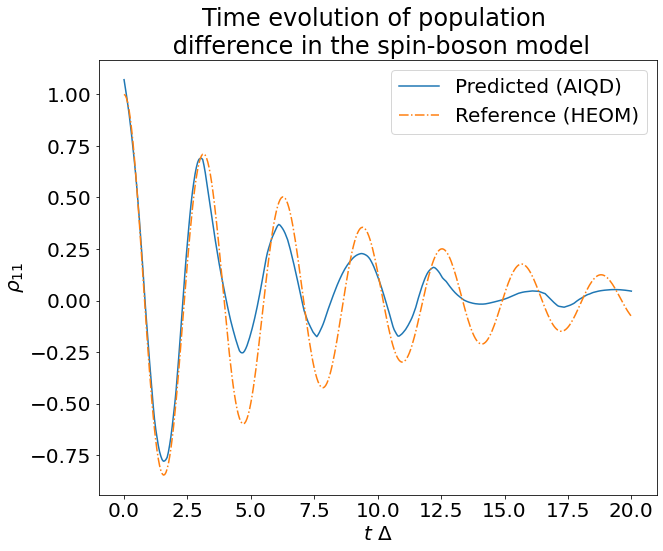

In [ ]:
heom_dyn = np.load('MLQD/Jupyter_Notebooks/test_set/sb/2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-4.0_beta-1.0.npy')
pred_dyn = np.load('Qd_trajectory.npy')
t_1 = np.real(heom_dyn[:,0])
t_2 = np.real(pred_dyn[:,0])
pred_state_1_pop = np.real(pred_dyn[:,1] - pred_dyn[:,4])
heom_state_1_pop = np.real(heom_dyn[:,1] - heom_dyn[:,4])

plt.rcParams['font.size'] = '20'
plt.figure(figsize=(10,8))
plt.plot(t_2, pred_state_1_pop, )
plt.plot(t_1, heom_state_1_pop, '-.')
plt.xlabel(r'$t \ \Delta$')
plt.ylabel(r'$\rho_{11}$')
plt.legend(["Predicted (AIQD)", 'Reference (HEOM)'])
plt.title('Time evolution of population \n difference in the spin-boson model')